In [1]:
import itertools
from functools import partial

import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax_tqdm import scan_tqdm

from special_unitary import (
    fast_expi_su3,
    special_unitary_grad,
    unitary_violation,
    proj_SU3
)

from integrators import int_MN2_omelyan
from gauge_field_utils import (
    wilson_action,
    wilson_gauge_error,
    luscher_weisz_action,
    luscher_weisz_gauge_error,
    wilson_loops_range,
    smear_HYP,
    smear_stout,
    mean_plaquette
)

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def HMC(action_fn, error_fn, integrator, tau_md=1.0, steps_md=10, unitary_violation_tol=5e-6):

    action_grad = special_unitary_grad(action_fn)
    
    def step_fn(links, random_key, skip_metropolis=False):
        key1, key2 = jax.random.split(random_key, 2)
        Nc = links.shape[-1]

        p0 = jax.random.normal(key1, shape=(*links.shape[:-2], Nc*Nc-1))

        links_next, p_final = integrator(links, p0, action_grad, tau_md, steps_md)
        links_next = jax.lax.cond(
            unitary_violation_tol is not None,
            lambda: jax.lax.cond(
                unitary_violation(links_next, "mean") > unitary_violation_tol,
                proj_SU3,
                lambda x: x,
                links_next
            ),
            lambda: links_next
        )

        delta_hamiltonian = error_fn(links, p0, links_next, p_final)
        p_acc = jnp.minimum(1, jnp.exp(-delta_hamiltonian))
        
        return jax.lax.cond(
            skip_metropolis,
            lambda: links_next,
            lambda: jax.lax.cond(
                jax.random.uniform(key2) < p_acc,
                lambda: links_next,
                lambda: links
            )
        ), (delta_hamiltonian, p_acc)
    
    return jax.jit(step_fn)

In [3]:
random_key, _k = jax.random.split(jax.random.key(0), num=2)

L = (16, 16, 16, 16)
gauge_links = fast_expi_su3(jax.random.normal(
    _k,
    shape=(*L, 4, 8),
    dtype=jnp.float32
))

stepper_fn = HMC(
    action_fn=partial(luscher_weisz_action, beta=8.30, u0=0.8953063457019701),
    error_fn=partial(luscher_weisz_gauge_error, beta=8.30, u0=0.8953063457019701),
    integrator=int_MN2_omelyan,
    tau_md=1.0,
    steps_md=20,
    unitary_violation_tol=5e-6,
)

In [6]:
for step in (bar := tqdm(range(1000))):
    random_key, _k = jax.random.split(random_key, num=2)

    gauge_links, aux = stepper_fn(gauge_links, _k)
    mean_plaq = mean_plaquette(gauge_links)
    jnp.save(f"../results/configs_3-24-25/step_{step}_gauge.npy", gauge_links)

    bar.set_postfix({
        "pl": mean_plaq,
        "delta_H": aux[0],
        "p_acc": aux[1]
    })

 22%|██▏       | 223/1000 [13:35<47:20,  3.66s/it, pl=1.87, delta_H=0.593, p_acc=0.553] 


KeyboardInterrupt: 

In [95]:
from glob import glob
with jax.default_matmul_precision("highest"):
    wilson_loops = np.stack([
        wilson_loops_range(smear_HYP(jnp.load(config)), R=10, T=10)
        for config in tqdm(sorted(glob("../results/configs_3-24-25/*.npy"), key=lambda x: int(x.split("_")[-2])))
    ])

100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


In [96]:
@partial(jax.jit, static_argnums=(1,))
def jackknife_stats(data, statistic):
    N = len(data)

    jack_estimates = jax.vmap(lambda x, i: statistic(jnp.delete(x, i, axis=0, assume_unique_indices=True)), in_axes=[None, 0])(data, jnp.arange(N))

    estimate = jnp.mean(jack_estimates, axis=0)
    # bias = (N - 1) * (estimate - statistic(data))
    stderr = jnp.sqrt((N - 1) * jnp.var(jack_estimates, axis=0, ddof=1))

    return estimate, stderr

In [97]:
mean_wilson_loops, err_wilson_loops = jackknife_stats(wilson_loops[60:].real, lambda x: jnp.mean(x, axis=0))

print(f"Mean plaquette: {mean_wilson_loops[0, 0]:.6f} ({err_wilson_loops[0, 0]:.6f})")

Mean plaquette: 2.850926 (0.000059)


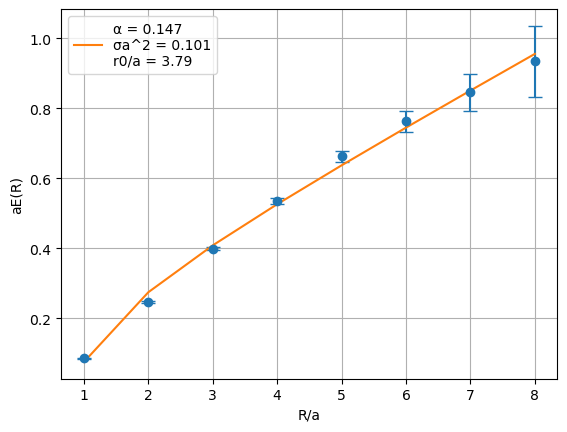

In [302]:
from jax.scipy.optimize import minimize

@jax.jit
def effective_potential(W1, W2, dW1, dW2):
    energy_fn = lambda x: jnp.log(x[0] / x[1])
    stderr_fn = lambda x, dx: jnp.sqrt(jnp.square(jax.grad(energy_fn)(x) * dx).sum())

    X = jnp.stack([W1, W2], axis=1)
    dX = jnp.stack([dW1, dW2], axis=1)

    V = jax.vmap(energy_fn, in_axes=(0,))(X)
    dV = jax.vmap(stderr_fn, in_axes=(0, 0))(X, dX)

    return V, dV

R_range = (0, 8)
T_level = 5

V, dV = effective_potential(mean_wilson_loops[R_range[0]:R_range[1], T_level], mean_wilson_loops[R_range[0]:R_range[1], T_level+1],
                    err_wilson_loops[R_range[0]:R_range[1], T_level], err_wilson_loops[R_range[0]:R_range[1], T_level+1])
R = (jnp.arange(len(V))+1+R_range[0]).astype(jnp.float32)

V0_latt, alpha_latt, sigma_latt = minimize(lambda x: jnp.square(x[0] - 4*x[1]/(3*R) + x[2]*R - V).mean(), x0=jnp.array([0.1, 0.1, 0.1]), method="BFGS").x
V_fit = V0_latt - 4*alpha_latt/(3*R) + sigma_latt*R
sommer_r0 = jnp.sqrt((1.65 - 4*alpha_latt/3) / sigma_latt)

plt.errorbar(R, V, dV, fmt='o', capsize=5)
plt.plot(R, V_fit, label=f"α = {alpha_latt:.3g}\nσa^2 = {sigma_latt:.3g}\nr0/a = {sommer_r0:.4g}")

plt.xlabel("R/a")
plt.ylabel("aE(R)")
plt.legend()
plt.grid()
plt.show()

In [296]:
# Sommer parameter with error according to https://arxiv.org/pdf/hep-lat/0112024
from scipy.optimize import curve_fit

def fit_func(t, E1, E2, c1, c2):
    return c1*np.exp(-E1*t) + c2*np.exp(-E2*t)

R = (jnp.arange(1, 10+1)).astype(jnp.float32)
V = np.min(np.stack([curve_fit(fit_func, xdata=np.arange(2, 9+1), ydata=mean_wilson_loops[i, 1:9], p0=np.array([0.1,]*4), maxfev=10000)[0][(0,1),] for i in range(10)]), axis=1)


R_min = [2, 3]
R_max = [7, 8, 9]

r0_vals = []
r1_vals = []

for rmin in R_min:
    for rmax in R_max:
        
        _, alpha_latt, sigma_latt = minimize(lambda x: jnp.square(x[0] - 4*x[1]/(3*R[rmin-1:rmax]) + x[2]*R[rmin-1:rmax] - V[rmin-1:rmax]).mean(), x0=jnp.array([0.1, 0.1, 0.1]), method="BFGS").x

        r0, r1 = jnp.sqrt((1.65 - 4*alpha_latt/3) / sigma_latt), jnp.sqrt((1.00 - 4*alpha_latt/3) / sigma_latt)
        r0_vals.append(r0)
        r1_vals.append(r1)

In [299]:
jackknife_stats(jnp.array(r0_vals), jnp.mean)

(Array(3.5373569, dtype=float32), Array(0.04310376, dtype=float32))